In [1]:
import gc
import time
import keras as k
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import mean_squared_error, accuracy_score, \
                            confusion_matrix, classification_report

pd.set_option('display.max_columns', None)

Using TensorFlow backend.


# Inspecting Data

In [2]:
df = pd.read_csv('../data/zscore_btc.csv',index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 837 entries, 7/10/2016 to 10/24/2018
Columns: 139 entries, com_count to bitcoin_close
dtypes: float64(139)
memory usage: 915.5+ KB


In [3]:
df.head()

,com_count,sub_count,com_body_pos_count,com_body_very_pos_count,com_body_neg_count,com_body_very_neg_count,sub_body_pos_count,sub_body_very_pos_count,sub_body_neg_count,sub_body_very_neg_count,sub_title_pos_count,sub_title_very_pos_count,sub_title_neg_count,sub_title_very_neg_count,sub_title_non_zero_pr,sub_title_top_50_pr,sub_title_top_75_pr,sub_title_pr_4_bins,sub_title_pr_normalized,sub_title_pr_norm_plus_base,sub_title_pos_non_zero_pr,sub_title_pos_top_50_pr,sub_title_pos_top_75_pr,sub_title_pos_pr_4_bins,sub_title_pos_pr_normalized,sub_title_pos_pr_norm_plus_base,sub_title_very_pos_non_zero_pr,sub_title_very_pos_top_50_pr,sub_title_very_pos_top_75_pr,sub_title_very_pos_pr_4_bins,sub_title_very_pos_pr_normalized,sub_title_very_pos_pr_norm_plus_base,sub_title_neg_non_zero_pr,sub_title_neg_top_50_pr,sub_title_neg_top_75_pr,sub_title_neg_pr_4_bins,sub_title_neg_pr_normalized,sub_title_neg_pr_norm_plus_base,sub_title_very_neg_non_zero_pr,sub_title_very_neg_top_50_pr,sub_title_very_neg_top_75_pr,sub_title_very_neg_pr_4_bins,sub_title_very_neg_pr_normalized,sub_title_very_neg_pr_norm_plus_base,sub_title_very_pos_minus_very_neg_non_zero_pr,sub_title_pos_minus_neg_non_zero_pr,sub_title_pos_non_zero_pr_percent,sub_title_very_pos_non_zero_pr_percent,sub_title_neg_non_zero_pr_percent,sub_title_very_neg_non_zero_pr_percent,sub_body_non_zero_pr,sub_body_top_50_pr,sub_body_top_75_pr,sub_body_pr_4_bins,sub_body_pr_normalized,sub_body_pr_norm_plus_base,sub_body_pos_non_zero_pr,sub_body_pos_top_50_pr,sub_body_pos_top_75_pr,sub_body_pos_pr_4_bins,sub_body_pos_pr_normalized,sub_body_pos_pr_norm_plus_base,sub_body_very_pos_non_zero_pr,sub_body_very_pos_top_50_pr,sub_body_very_pos_top_75_pr,sub_body_very_pos_pr_4_bins,sub_body_very_pos_pr_normalized,sub_body_very_pos_pr_norm_plus_base,sub_body_neg_non_zero_pr,sub_body_neg_top_50_pr,sub_body_neg_top_75_pr,sub_body_neg_pr_4_bins,sub_body_neg_pr_normalized,sub_body_neg_pr_norm_plus_base,sub_body_very_neg_non_zero_pr,sub_body_very_neg_top_50_pr,sub_body_very_neg_top_75_pr,sub_body_very_neg_pr_4_bins,sub_body_very_neg_pr_normalized,sub_body_very_neg_pr_norm_plus_base,sub_body_very_pos_minus_very_neg_non_zero_pr,sub_body_pos_minus_neg_non_zero_pr,sub_body_pos_non_zero_pr_percent,sub_body_very_pos_non_zero_pr_percent,sub_body_neg_non_zero_pr_percent,sub_body_very_neg_non_zero_pr_percent,com_body_non_zero_pr,com_body_top_50_pr,com_body_top_75_pr,com_body_pr_4_bins,com_body_pr_normalized,com_body_pr_norm_plus_base,com_body_pos_non_zero_pr,com_body_pos_top_50_pr,com_body_pos_top_75_pr,com_body_pos_pr_4_bins,com_body_pos_pr_normalized,com_body_pos_pr_norm_plus_base,com_body_very_pos_non_zero_pr,com_body_very_pos_top_50_pr,com_body_very_pos_top_75_pr,com_body_very_pos_pr_4_bins,com_body_very_pos_pr_normalized,com_body_very_pos_pr_norm_plus_base,com_body_neg_non_zero_pr,com_body_neg_top_50_pr,com_body_neg_top_75_pr,com_body_neg_pr_4_bins,com_body_neg_pr_normalized,com_body_neg_pr_norm_plus_base,com_body_very_neg_non_zero_pr,com_body_very_neg_top_50_pr,com_body_very_neg_top_75_pr,com_body_very_neg_pr_4_bins,com_body_very_neg_pr_normalized,com_body_very_neg_pr_norm_plus_base,com_body_very_pos_minus_very_neg_non_zero_pr,com_body_pos_minus_neg_non_zero_pr,com_body_pos_non_zero_pr_percent,com_body_very_pos_non_zero_pr_percent,com_body_neg_non_zero_pr_percent,com_body_very_neg_non_zero_pr_percent,avg_clust_coef,avg_degree,num_edges,num_nodes,com_body_pos_percent,com_body_very_pos_percent,com_body_neg_percent,com_body_very_neg_percent,sub_body_pos_percent,sub_body_very_pos_percent,sub_body_neg_percent,sub_body_very_neg_percent,sub_title_pos_percent,sub_title_very_pos_percent,sub_title_neg_percent,sub_title_very_neg_percent,bitcoin_close
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7/10/2016,-1.883750,-1.321221,-1.785986,-1.721442,-1.711227,-1.466842,-1.842558,-1.232573,-0.269408,-1.109361,-0.503556,-0.247316,-1.6465

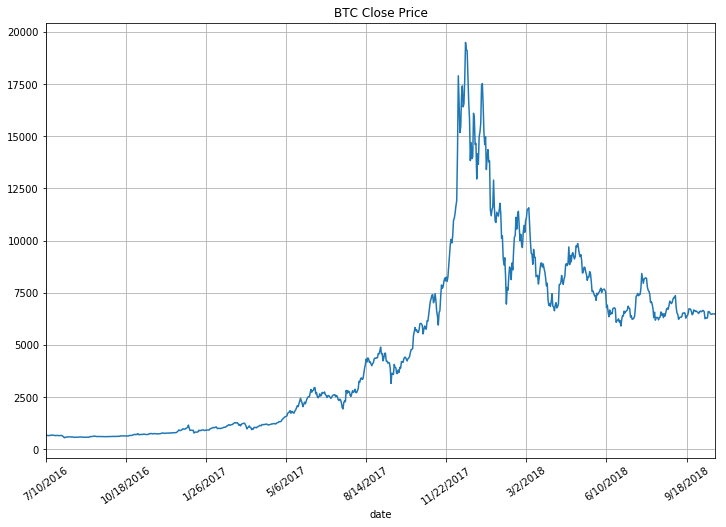

In [4]:
# show closing price time series
df['bitcoin_close'].plot(title='BTC Close Price',grid=True,rot=35, figsize=(12,8))

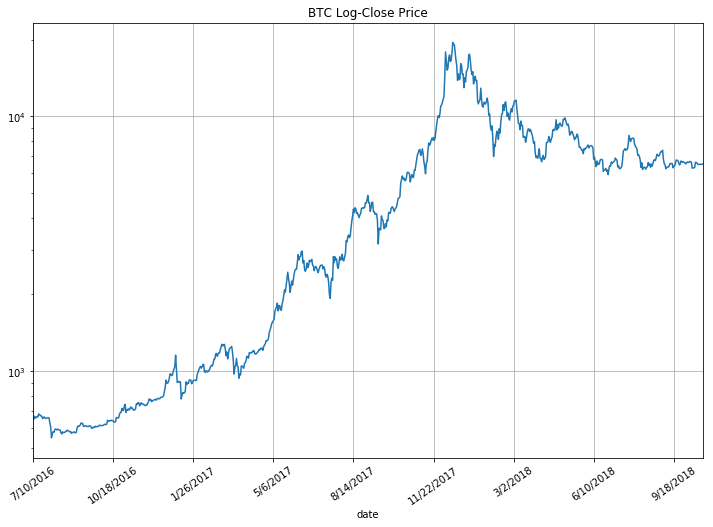

In [5]:
# show log-closing price time series
df['bitcoin_close'].plot(title='BTC Log-Close Price',grid=True,logy=True,rot=35, figsize=(12,8))

In [6]:
# stats on time series length
print("number of days:  {:.1f}".format(df.shape[0]))
print("number of months:  {:.1f}".format(df.shape[0] / 30))
print("number of years:    {:.1f}".format(df.shape[0] / 365))

number of days:  837.0
number of months:  27.9
number of years:    2.3


# Defining Functions

## Loading and Preparing Data

In [7]:
# function to read in dataset

def get_data(curr='btc'):
    if curr.lower() not in ['btc', 'eth']:
        raise ValueError('Must be BTC or ETH')
    return pd.read_csv('../data/zscore_{}.csv'.format(curr.lower()), index_col='date')

In [8]:
# function to drop unneeded fields

def keep_only_close(df_in, curr='btc'):
    if curr.lower() == 'btc':
        drops = ['bitcoin_open', 'bitcoin_high', 'bitcoin_low',
                 'bitcoin_volume', 'bitcoin_market_cap']
    elif curr.lower() == 'eth':
        drops = ['eth_open', 'eth_high', 'eth_low',
                 'eth_volume', 'eth_market_cap']
    else:
        raise ValueError('Must be BTC or ETH for lags')
    return df_in.drop(drops, axis=1) 

In [9]:
# function to add predicted column for tomorrow's close price

def add_prediction_field(df_in, curr='btc'):
    if curr.lower() == 'btc':
        name = 'bitcoin'
    elif curr.lower() == 'eth':
        name = 'eth'
    else:
        raise ValueError('Must be BTC or ETH for lags')
    
    # creating predicted value
    # create column to hold tomorrow's close for each day
    df_in['tomorrow_close'] = df_in['{}_close'.format(name)].shift(-1)
    # change in price between consecutive closing days
    df_in['day_change'] = df_in['tomorrow_close'] - df_in['{}_close'.format(name)]
    # indicator variable to be used for predicting higher/lower days
    df_in['y'] = np.where(df_in['day_change'] >= 0, 1, 0)
        
    # drop intermediate columns
    return df_in.drop(['tomorrow_close', 'day_change'], axis=1)

In [10]:
# function to retrieve lag values to use for each feature

def get_feature_lag_dict(curr='btc'):
    # check value of input
    if curr.lower() not in ['btc', 'eth']:
        raise ValueError('Must be BTC or ETH for lags')
    
    # read in right version of file
    df = pd.read_csv('../lags/optimal_lags_{}.csv'.format(curr.lower()))
    
    # return dictionary of features as keys and lags as values
    return dict(zip(df.feature, df.lags))

In [11]:
# function to add lags for daily features

def add_lags(df_in, curr='btc'):
    # splitting into X/y for separate processing
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    # save list of columns for lags
    col_list = X.columns
    # create output DF
    df_out = X.copy()
    
    # creating lags
    f_dict = get_feature_lag_dict(curr=curr)
    # create lag columns for each other variable
    for col in col_list:
        if col not in f_dict.keys(): continue
        for lag in range(int(f_dict[col])-1):
            df_out['{}_(-{})'.format(col,lag+1)] = df_out[col].shift(lag+1)

    if curr=='btc': 
        col = 'bitcoin_close'
    elif curr=='eth':
        col = 'eth_close'
    for lag in range(9):
        df_out['{}_(-{})'.format(col,lag+1)] = df_out[col].shift(lag+1)
            
    # return and drop na
    df_out['y'] = y
    return df_out.dropna()

In [12]:
# function to remove data before certain date

def truncate_date(df_in, first_day='1999-1-1'):
    # set mask of Bool values
    mask = (pd.to_datetime(df_in.index) >= first_day)
    return df_in.loc[mask]

In [13]:
# function to rejoin training data into X/y again

def rejoin_training_data(X_train, X_test, y_train, y_test):
    Xs = [X_train, X_test]
    Ys = [y_train, y_test]
    
    df_out = pd.concat(Xs)
    df_out['y'] = pd.concat(Ys)
    
    return df_out

In [14]:
# function to create train/test X and y
def create_training_data(df_in, curr='btc', train_split=0.7, rescale=True, k_feat_perc=None):
    # split into test train
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    
    # determine cutoff of train/test split and split
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]
    
    # scale values to 0-1
    # must only scale based on training data, to ensure no 
    # foresight with averages
    if rescale:
        scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train.values)
        cols = X.columns
        X_train = pd.DataFrame(scaler.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(scaler.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # select top K features to use
    if k_feat_perc:
        selector = SelectPercentile(chi2, percentile=k_feat_perc).fit(
                                    X_train.values,y_train.values)
        # index and names of remainig columns after filter
        cols = X_train.columns[selector.get_support(indices = True)]
        X_train = pd.DataFrame(selector.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(selector.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # recreate into X/y DF and add lags
    df_renew = rejoin_training_data(X_train, X_test, y_train, y_test)
    df_renew = add_lags(df_renew, curr=curr)
    
    # split into test train again
    X, y = df_renew[df_renew.columns[:-1]], df_renew[df_renew.columns[-1]]
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]

    # display shapes
    print('='*65)
    print('New Training Set')
    print('Training Set Dims: {}'.format(X_train.shape))
    print('Testing Set Dims:  {}'.format(X_test.shape))
    print('='*65)

    return X_train, X_test, y_train, y_test

In [15]:
# function to prep data and return DF for modeling

def prepare_data(curr='btc',train_split=0.7, close_o=False, 
                         first_day=None, rescale=True, k_feat_perc=None):
    # read in  dataset and initialize output df
    df_in = get_data(curr)
    
    # drop non-price fields if needed
    if close_o:
        df_in = keep_only_close(df_in, curr=curr)
    
    # add prediction field
    df_in = add_prediction_field(df_in, curr=curr)
    
    # cut off prior to first_day
    if first_day:
        df_in = truncate_date(df_in, first_day)
    
    return create_training_data(df_in.dropna(), curr=curr, train_split=train_split, 
                                rescale=rescale, k_feat_perc=k_feat_perc)

## Preparing Data for Training

In [16]:
# split dataset
X_train, X_test, y_train, y_test = prepare_data(curr='eth', train_split=0.9, close_o=False, 
                                    first_day=None, rescale=False, k_feat_perc=None)

New Training Set
Training Set Dims: (741, 786)
Testing Set Dims:  (83, 786)


In [17]:
X_train.head()

,com_count,sub_count,com_body_pos_count,com_body_very_pos_count,com_body_neg_count,com_body_very_neg_count,sub_body_pos_count,sub_body_very_pos_count,sub_body_neg_count,sub_body_very_neg_count,sub_title_pos_count,sub_title_very_pos_count,sub_title_neg_count,sub_title_very_neg_count,sub_title_non_zero_pr,sub_title_top_50_pr,sub_title_top_75_pr,sub_title_pr_4_bins,sub_title_pr_normalized,sub_title_pr_norm_plus_base,sub_title_pos_non_zero_pr,sub_title_pos_top_50_pr,sub_title_pos_top_75_pr,sub_title_pos_pr_4_bins,sub_title_pos_pr_normalized,sub_title_pos_pr_norm_plus_base,sub_title_very_pos_non_zero_pr,sub_title_very_pos_top_50_pr,sub_title_very_pos_top_75_pr,sub_title_very_pos_pr_4_bins,sub_title_very_pos_pr_normalized,sub_title_very_pos_pr_norm_plus_base,sub_title_neg_non_zero_pr,sub_title_neg_top_50_pr,sub_title_neg_top_75_pr,sub_title_neg_pr_4_bins,sub_title_neg_pr_normalized,sub_title_neg_pr_norm_plus_base,sub_title_very_neg_non_zero_pr,sub_title_very_neg_top_50_pr,sub_title_very_neg_top_75_pr,sub_title_very_neg_pr_4_bins,sub_title_very_neg_pr_normalized,sub_title_very_neg_pr_norm_plus_base,sub_title_very_pos_minus_very_neg_non_zero_pr,sub_title_pos_minus_neg_non_zero_pr,sub_title_pos_non_zero_pr_percent,sub_title_very_pos_non_zero_pr_percent,sub_title_neg_non_zero_pr_percent,sub_title_very_neg_non_zero_pr_percent,sub_body_non_zero_pr,sub_body_top_50_pr,sub_body_top_75_pr,sub_body_pr_4_bins,sub_body_pr_normalized,sub_body_pr_norm_plus_base,sub_body_pos_non_zero_pr,sub_body_pos_top_50_pr,sub_body_pos_top_75_pr,sub_body_pos_pr_4_bins,sub_body_pos_pr_normalized,sub_body_pos_pr_norm_plus_base,sub_body_very_pos_non_zero_pr,sub_body_very_pos_top_50_pr,sub_body_very_pos_top_75_pr,sub_body_very_pos_pr_4_bins,sub_body_very_pos_pr_normalized,sub_body_very_pos_pr_norm_plus_base,sub_body_neg_non_zero_pr,sub_body_neg_top_50_pr,sub_body_neg_top_75_pr,sub_body_neg_pr_4_bins,sub_body_neg_pr_normalized,sub_body_neg_pr_norm_plus_base,sub_body_very_neg_non_zero_pr,sub_body_very_neg_top_50_pr,sub_body_very_neg_top_75_pr,sub_body_very_neg_pr_4_bins,sub_body_very_neg_pr_normalized,sub_body_very_neg_pr_norm_plus_base,sub_body_very_pos_minus_very_neg_non_zero_pr,sub_body_pos_minus_neg_non_zero_pr,sub_body_pos_non_zero_pr_percent,sub_body_very_pos_non_zero_pr_percent,sub_body_neg_non_zero_pr_percent,sub_body_very_neg_non_zero_pr_percent,com_body_non_zero_pr,com_body_top_50_pr,com_body_top_75_pr,com_body_pr_4_bins,com_body_pr_normalized,com_body_pr_norm_plus_base,com_body_pos_non_zero_pr,com_body_pos_top_50_pr,com_body_pos_top_75_pr,com_body_pos_pr_4_bins,com_body_pos_pr_normalized,com_body_pos_pr_norm_plus_base,com_body_very_pos_non_zero_pr,com_body_very_pos_top_50_pr,com_body_very_pos_top_75_pr,com_body_very_pos_pr_4_bins,com_body_very_pos_pr_normalized,com_body_very_pos_pr_norm_plus_base,com_body_neg_non_zero_pr,com_body_neg_top_50_pr,com_body_neg_top_75_pr,com_body_neg_pr_4_bins,com_body_neg_pr_normalized,com_body_neg_pr_norm_plus_base,com_body_very_neg_non_zero_pr,com_body_very_neg_top_50_pr,com_body_very_neg_top_75_pr,com_body_very_neg_pr_4_bins,com_body_very_neg_pr_normalized,com_body_very_neg_pr_norm_plus_base,com_body_very_pos_minus_very_neg_non_zero_pr,com_body_pos_minus_neg_non_zero_pr,com_body_pos_non_zero_pr_percent,com_body_very_pos_non_zero_pr_percent,com_body_neg_non_zero_pr_percent,com_body_very_neg_non_zero_pr_percent,avg_clust_coef,avg_degree,num_edges,num_nodes,com_body_pos_percent,com_body_very_pos_percent,com_body_neg_percent,com_body_very_neg_percent,sub_body_pos_percent,sub_body_very_pos_percent,sub_body_neg_percent,sub_body_very_neg_percent,sub_title_pos_percent,sub_title_very_pos_percent,sub_title_neg_percent,sub_title_very_neg_percent,eth_close,com_count_(-1),com_count_(-2),com_count_(-3),com_count_(-4),sub_count_(-1),sub_count_(-2),sub_count_(-3),sub_count_(-4),sub_count_(-5),com_body_pos_count_(-1),com_body_pos_count_(-2),com_body_pos_count_(-3),com_body_pos_count_(-4),com_body_pos_count_(-5),com_body_very_pos_count_(-1),c

In [18]:
X_train.shape

(741, 786)

In [19]:
X_test.shape

(83, 786)

In [20]:
y_train.shape

(741,)

In [21]:
y_test.shape

(83,)

In [22]:
# balance of dependent variable values
ones = y_train.sum()
zeros = y_train.shape[0] - ones
print("0's: {}".format(zeros))
print("1's: {}".format(ones))

0's: 369
1's: 372


In [23]:
# balance of dependent variable values
ones = y_test.sum()
zeros = y_test.shape[0] - ones
print("0's: {}".format(zeros))
print("1's: {}".format(ones))

0's: 49
1's: 34


## Build, Train, Test Logistic Regression Model

In [24]:
model = LogisticRegression(C=1, solver='lbfgs')
model.fit(X_train,y_train)

C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
# function to create and train model

def run_model(C=1.0, data=None):
    
    X_train, X_test, y_train, y_test = data
    
    # bulid and fit model
    model = LogisticRegression(C=C, solver='lbfgs')
    model.fit(X_train, y_train)
    
    # evaluate
    y_pred = np.round(model.predict(X_test))
    accuracy = accuracy_score(y_test, y_pred) * 100
    print("\nAccuracy: {:.2f}%".format(accuracy))
    
    # print confusion matrix
    print('\nConfusion Matrix')
    print('='*20)
    cm = confusion_matrix(y_test, y_pred)    
    print(pd.DataFrame(cm, index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes']))
    
    # print classification report
    print('\nClasification Report')
    print('='*20)
    print(classification_report(y_test, y_pred, labels=[0,1]))
    
    return model, accuracy, cm

In [26]:
model, acc, cm  = run_model(C=10, data = (X_train, X_test, y_train, y_test))

C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Accuracy: 43.37%

Confusion Matrix
          pred:no  pred:yes
true:no        20        29
true:yes       18        16

Clasification Report
              precision    recall  f1-score   support

           0       0.53      0.41      0.46        49
           1       0.36      0.47      0.41        34

   micro avg       0.43      0.43      0.43        83
   macro avg       0.44      0.44      0.43        83
weighted avg       0.46      0.43      0.44        83



## Optimizing Training and Logistic Regression Parameters

In [27]:
def run_simulations(curr='btc', k_feat_perc=50, uniques=True, 
                    timer=True, close_o=False, first_day='2016-7-1'):
    # run all simulations to find best model
    if timer:
        start = time.time()
    
    # train/test splits
    train_splits = [0.9]
    
    # C regularizaiton parameter
    Cs = [0.01, 0.1, 1, 10, 100, 1000, 5000, 10000, 15000]
    
    # RUN
    # number of reports to keep track
    report = 0
    dashes = 53
    scores = dict()
    cms = dict()
    
    # data preparation parameters

    # read in data and create lags
    for split in train_splits:
        # create training and test data
        data = prepare_data(curr=curr, train_split=split, 
                                            close_o=close_o, first_day=first_day, rescale=False, 
                                            k_feat_perc=k_feat_perc)

        # run all simulations of for modeling parameters
        for c in Cs:
            # print output
            report += 1
            print('='*dashes)
            print('REPORT # {}'.format(report))
            print('='*dashes)
            print('Training Parameters')
            print('Currency          = {}'.format(curr.upper()))
            print('Training Data %   = {:0.1f}%'.format(split*100))
            print('='*dashes)
            print('Model Parameters')
            print('C                 = {}'.format(c))
            print('='*dashes)
            # execute model
            model, acc, cm = run_model(C=c, data=data)
            scores[report] = acc
            cms[report] = cm
            print('='*dashes)
    
    # calculate max accuracy from all reports
    # and true pos/neg
    max_rep, max_acc = max(scores.items(), key=lambda x: x[1])
    max_cm = cms[max_rep]
    tp = float(max_cm[0][0])/np.sum(max_cm[0])
    tn = float(max_cm[1][1])/np.sum(max_cm[1])
    
    
    print('\n')
    print('='*dashes)
    print('='*dashes)
    print('BEST MODEL')
    print('REPORT # {}'.format(max_rep))
    print('ACCURACY {:0.2f}%'.format(max_acc))
    print('TRUE POS {:0.2f}%'.format(tp * 100))
    print('TRUE NEG {:0.2f}%'.format(tn * 100))
    print('='*dashes)
    print('='*dashes)
    
    
    if timer:
        end = time.time()
        print('Process took {:.2f} seconds'.format(end-start))

## Running Parameter Sweeps - Logistic Regression

## From July 2016 Onward

## BTC

### 100% of Features

In [28]:
# run all simulations for 100% attributes
run_simulations(k_feat_perc=None, first_day=None)

New Training Set
Training Set Dims: (741, 570)
Testing Set Dims:  (83, 570)
REPORT # 1
Training Parameters
Currency          = BTC
Training Data %   = 90.0%
Model Parameters
C                 = 0.01

Accuracy: 55.42%

Confusion Matrix
          pred:no  pred:yes
true:no        16        26
true:yes       11        30

Clasification Report
              precision    recall  f1-score   support

           0       0.59      0.38      0.46        42
           1       0.54      0.73      0.62        41

   micro avg       0.55      0.55      0.55        83
   macro avg       0.56      0.56      0.54        83
weighted avg       0.56      0.55      0.54        83

REPORT # 2
Training Parameters
Currency          = BTC
Training Data %   = 90.0%
Model Parameters
C                 = 0.1


C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Accuracy: 57.83%

Confusion Matrix
          pred:no  pred:yes
true:no        18        24
true:yes       11        30

Clasification Report
              precision    recall  f1-score   support

           0       0.62      0.43      0.51        42
           1       0.56      0.73      0.63        41

   micro avg       0.58      0.58      0.58        83
   macro avg       0.59      0.58      0.57        83
weighted avg       0.59      0.58      0.57        83

REPORT # 3
Training Parameters
Currency          = BTC
Training Data %   = 90.0%
Model Parameters
C                 = 1

Accuracy: 51.81%

Confusion Matrix
          pred:no  pred:yes
true:no        10        32
true:yes        8        33

Clasification Report
              precision    recall  f1-score   support

           0       0.56      0.24      0.33        42
           1       0.51      0.80      0.62        41

   micro avg       0.52      0.52      0.52        83
   macro avg       0.53      0.52      0.48        

C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Accuracy: 55.42%

Confusion Matrix
          pred:no  pred:yes
true:no        19        23
true:yes       14        27

Clasification Report
              precision    recall  f1-score   support

           0       0.58      0.45      0.51        42
           1       0.54      0.66      0.59        41

   micro avg       0.55      0.55      0.55        83
   macro avg       0.56      0.56      0.55        83
weighted avg       0.56      0.55      0.55        83

REPORT # 6
Training Parameters
Currency          = BTC
Training Data %   = 90.0%
Model Parameters
C                 = 1000

Accuracy: 57.83%

Confusion Matrix
          pred:no  pred:yes
true:no        14        28
true:yes        7        34

Clasification Report
              precision    recall  f1-score   support

           0       0.67      0.33      0.44        42
           1       0.55      0.83      0.66        41

   micro avg       0.58      0.58      0.58        83
   macro avg       0.61      0.58      0.55     

C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## ETH

### 100% of Features

In [29]:
# run all simulations for 100% attributes
run_simulations(curr='eth',k_feat_perc=None, first_day=None)

New Training Set
Training Set Dims: (741, 786)
Testing Set Dims:  (83, 786)
REPORT # 1
Training Parameters
Currency          = ETH
Training Data %   = 90.0%
Model Parameters
C                 = 0.01

Accuracy: 44.58%

Confusion Matrix
          pred:no  pred:yes
true:no        23        26
true:yes       20        14

Clasification Report
              precision    recall  f1-score   support

           0       0.53      0.47      0.50        49
           1       0.35      0.41      0.38        34

   micro avg       0.45      0.45      0.45        83
   macro avg       0.44      0.44      0.44        83
weighted avg       0.46      0.45      0.45        83

REPORT # 2
Training Parameters
Currency          = ETH
Training Data %   = 90.0%
Model Parameters
C                 = 0.1


C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Accuracy: 51.81%

Confusion Matrix
          pred:no  pred:yes
true:no        25        24
true:yes       16        18

Clasification Report
              precision    recall  f1-score   support

           0       0.61      0.51      0.56        49
           1       0.43      0.53      0.47        34

   micro avg       0.52      0.52      0.52        83
   macro avg       0.52      0.52      0.51        83
weighted avg       0.54      0.52      0.52        83

REPORT # 3
Training Parameters
Currency          = ETH
Training Data %   = 90.0%
Model Parameters
C                 = 1

Accuracy: 40.96%

Confusion Matrix
          pred:no  pred:yes
true:no        20        29
true:yes       20        14

Clasification Report
              precision    recall  f1-score   support

           0       0.50      0.41      0.45        49
           1       0.33      0.41      0.36        34

   micro avg       0.41      0.41      0.41        83
   macro avg       0.41      0.41      0.41        

C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Accuracy: 43.37%

Confusion Matrix
          pred:no  pred:yes
true:no        20        29
true:yes       18        16

Clasification Report
              precision    recall  f1-score   support

           0       0.53      0.41      0.46        49
           1       0.36      0.47      0.41        34

   micro avg       0.43      0.43      0.43        83
   macro avg       0.44      0.44      0.43        83
weighted avg       0.46      0.43      0.44        83

REPORT # 5
Training Parameters
Currency          = ETH
Training Data %   = 90.0%
Model Parameters
C                 = 100


C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Accuracy: 44.58%

Confusion Matrix
          pred:no  pred:yes
true:no        22        27
true:yes       19        15

Clasification Report
              precision    recall  f1-score   support

           0       0.54      0.45      0.49        49
           1       0.36      0.44      0.39        34

   micro avg       0.45      0.45      0.45        83
   macro avg       0.45      0.45      0.44        83
weighted avg       0.46      0.45      0.45        83

REPORT # 6
Training Parameters
Currency          = ETH
Training Data %   = 90.0%
Model Parameters
C                 = 1000

Accuracy: 44.58%

Confusion Matrix
          pred:no  pred:yes
true:no        23        26
true:yes       20        14

Clasification Report
              precision    recall  f1-score   support

           0       0.53      0.47      0.50        49
           1       0.35      0.41      0.38        34

   micro avg       0.45      0.45      0.45        83
   macro avg       0.44      0.44      0.44     

C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Accuracy: 42.17%

Confusion Matrix
          pred:no  pred:yes
true:no        21        28
true:yes       20        14

Clasification Report
              precision    recall  f1-score   support

           0       0.51      0.43      0.47        49
           1       0.33      0.41      0.37        34

   micro avg       0.42      0.42      0.42        83
   macro avg       0.42      0.42      0.42        83
weighted avg       0.44      0.42      0.43        83

REPORT # 8
Training Parameters
Currency          = ETH
Training Data %   = 90.0%
Model Parameters
C                 = 10000

Accuracy: 45.78%

Confusion Matrix
          pred:no  pred:yes
true:no        23        26
true:yes       19        15

Clasification Report
              precision    recall  f1-score   support

           0       0.55      0.47      0.51        49
           1       0.37      0.44      0.40        34

   micro avg       0.46      0.46      0.46        83
   macro avg       0.46      0.46      0.45    

C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
